# OLA - Ensemble Learning

## Introduction

In response to the growing challenge of driver attrition, a comprehensive analysis was conducted to predict driver churn for Ola. High churn rates not only increase operational costs but also affect driver morale and customer service. This project utilized ensemble learning techniques, specifically bagging and boosting methods, to enhance predictive accuracy and provide actionable insights for improving driver retention strategies.

## Problem Statement

Ola faces a significant problem with high churn rates among its drivers. As competition increases, understanding the factors contributing to driver attrition becomes essential. By analyzing various attributes—such as demographics, performance metrics, and historical data—the aim was to predict which drivers are likely to leave the company. This predictive insight will help in formulating targeted retention efforts.



In [1856]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold, cross_validate, cross_val_score
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

In [1857]:
data = pd.read_csv('ola.csv')
data.head()

/usr/local/lib/python3.10/dist-packages/google/colab/_dataframe_summarizer.py:88: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cast_date_col = pd.to_datetime(column, errors="coerce")


,Unnamed: 0,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,0,01/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,2381060,2
1,1,02/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,-665480,2
2,2,03/01/19,1,28.0,0.0,C23,2,57387,24/12/18,03/11/19,1,1,0,2
3,3,11/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1
4,4,12/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1


In [1858]:
data.shape

(19104, 14)

In [1859]:
data.dtypes

,0
Unnamed: 0,int64
MMM-YY,object
Driver_ID,int64
Age,float64
Gender,float64
City,object
Education_Level,int64
Income,int64
Dateofjoining,object
LastWorkingDate,object


In [1860]:
data.isnull().sum()

,0
Unnamed: 0,0
MMM-YY,0
Driver_ID,0
Age,61
Gender,52
City,0
Education_Level,0
Income,0
Dateofjoining,0
LastWorkingDate,17488


In [1861]:
data.columns

Index(['Unnamed: 0', 'MMM-YY', 'Driver_ID', 'Age', 'Gender', 'City',
       'Education_Level', 'Income', 'Dateofjoining', 'LastWorkingDate',
       'Joining Designation', 'Grade', 'Total Business Value',
       'Quarterly Rating'],
      dtype='object')

In [1862]:
data.describe()

,Unnamed: 0,Driver_ID,Age,Gender,Education_Level,Income,Joining Designation,Grade,Total Business Value,Quarterly Rating
count,19104.000000,19104.000000,19043.000000,19052.000000,19104.000000,19104.000000,19104.000000,19104.000000,1.910400e+04,19104.000000
mean,9551.500000,1415.591133,34.668435,0.418749,1.021671,65652.025126,1.690536,2.252670,5.716621e+05,2.008899
std,5514.994107,810.705321,6.257912,0.493367,0.800167,30914.515344,0.836984,1.026512,1.128312e+06,1.009832
min,0.000000,1.000000,21.000000,0.000000,0.000000,10747.000000,1.000000,1.000000,-6.000000e+06,1.000000
25%,4775.750000,710.000000,30.000000,0.000000,0.000000,42383.000000,1.000000,1.000000,0.000000e+00,1.000000
50%,9551.500000,1417.000000,34.000000,0.000000,1.000000,60087.000000,1.000000,2.000000,2.500000e+05,2.000000
75%,14327.250000,2137.000000,39.000000,1.000000,2.000000,83969.000000,2.000000,3.000000,6.997000e+05,3.000000
max,19103.000000,2788.000000,58.000000,1.000000,2.000000,188418.000000,5.000000,5.000000,3.374772e+07,4.000000


In [1863]:
data['Dateofjoining'] = pd.to_datetime(data['Dateofjoining'],format='%d/%m/%y',dayfirst=True)

In [1864]:
data['LastWorkingDate'] = pd.to_datetime(data['LastWorkingDate'],format='%d/%m/%y',dayfirst=True)

In [1865]:
data.dtypes

,0
Unnamed: 0,int64
MMM-YY,object
Driver_ID,int64
Age,float64
Gender,float64
City,object
Education_Level,int64
Income,int64
Dateofjoining,datetime64[ns]
LastWorkingDate,datetime64[ns]


In [1866]:
data['Driver_ID'].value_counts().head(3)

,count
Driver_ID,
2110,24
2617,24
1623,24


## Aggregating Driver Data for Analysis

The code snippet focuses on aggregating driver data to create a unique dataset (`data_uniq`) for each driver in the Ola dataset.

1. **Feature Selection**: Two categories of features are defined:
   - `last_reported_features`: Includes attributes such as `Age`, `Gender`, `City`, `Education_Level`, `Dateofjoining`, `LastWorkingDate`, `Joining Designation`, and `Grade`. These represent the most recent values for each driver.
   - `average_features`: Contains `Income` and `Quarterly Rating`, which are averaged over the driver's tenure.

2. **Creating Unique Driver Dataset**:
   - A new DataFrame, `data_uniq`, is initialized to store unique driver records. The unique `Driver_ID`s are extracted from the original dataset.

3. **Aggregating Features**:
   - For each feature in `last_reported_features`, the code retrieves the last reported value for each driver using the `groupby` method and assigns it to `data_uniq`.
   - For features in `average_features`, the code computes the mean value for each driver and adds it to `data_uniq`.
   - Additionally, the total business value generated by each driver is calculated using the sum of `Total Business Value`.
   - The total number of reports (records) for each driver is also counted and added as `NumberOfReports`.

This aggregation process creates a concise dataset that captures essential information about each driver, which is crucial for subsequent analysis and modeling.



In [1867]:
last_reported_features = ['Age','Gender','City','Education_Level','Dateofjoining',
                          'LastWorkingDate','Joining Designation','Grade']

average_features = ['Income','Quarterly Rating']

data_uniq = pd.DataFrame()
data_uniq['Driver_ID'] = data['Driver_ID'].unique()
for feature in last_reported_features:
    data_uniq[feature] = data.groupby('Driver_ID')[feature].last().values

for feature in average_features:
    data_uniq[feature] = data.groupby('Driver_ID')[feature].mean().values

data_uniq['TotalBusinessValue'] = data.groupby('Driver_ID')['Total Business Value'].sum().values
data_uniq['NumberOfReports'] = data.groupby('Driver_ID').size().values


In [1868]:
data_uniq.shape

(2381, 13)

## Data Preparation for KNN Imputation

The code snippet prepares the dataset for KNN imputation by focusing on numerical features:

1. **Feature Selection**: Numerical features are extracted from the dataset for imputation, as KNN requires numerical data.

2. **Missing Value Assessment**: The code checks for missing values in these numerical features, which is crucial before imputation.

3. **KNN Imputation Setup**: A KNN model (e.g., `KNeighborsRegressor`) is typically initialized to estimate and fill in missing values based on the nearest neighbors.

This preparation is vital for ensuring a clean dataset, enhancing the accuracy of predictive modeling in later analyses.


In [1869]:
# 'Churned' feature: 1 if the driver has a 'LastWorkingDate', otherwise 0
data_uniq['Churned'] = data_uniq['LastWorkingDate'].notna().astype(int)

## Extracting Date Components from Joining Date

Extracts the year, month, and day from the `Dateofjoining` column in `data_uniq` and converts them into separate integer columns: `JoiningYear`, `JoiningMonth`, and `JoiningDay`.


In [1870]:
# Extracting year, month, and day, then convert them to integers
data_uniq['JoiningYear'] = data_uniq['Dateofjoining'].dt.year
data_uniq['JoiningMonth'] = data_uniq['Dateofjoining'].dt.month
data_uniq['JoiningDay'] = data_uniq['Dateofjoining'].dt.day

data_uniq.head()

,Driver_ID,Age,Gender,City,Education_Level,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Income,Quarterly Rating,TotalBusinessValue,NumberOfReports,Churned,JoiningYear,JoiningMonth,JoiningDay
0,1,28.0,0.0,C23,2,2018-12-24,2019-11-03,1,1,57387.0,2.0,1715580,3,1,2018,12,24
1,2,31.0,0.0,C7,2,2020-06-11,NaT,2,2,67016.0,1.0,0,2,0,2020,6,11
2,4,43.0,0.0,C13,2,2019-07-12,2020-04-27,2,2,65603.0,1.0,350000,5,1,2019,7,12
3,5,29.0,0.0,C9,0,2019-09-01,2019-07-03,1,1,46368.0,1.0,120360,3,1,2019,9,1
4,6,31.0,1.0,C11,1,2020-07-31,NaT,3,3,78728.0,1.6,1265000,5,0,2020,7,31


In [1871]:
data_uniq.dtypes

,0
Driver_ID,int64
Age,float64
Gender,float64
City,object
Education_Level,int64
Dateofjoining,datetime64[ns]
LastWorkingDate,datetime64[ns]
Joining Designation,int64
Grade,int64
Income,float64


## Creating a Random Sample for Testing

Randomly selects 100 rows from the `data_uniq` dataset for testing and removes those rows from the original dataset, ensuring a clear separation between training and testing data.


In [1872]:
# Randomly selecting 100 rows from the dataset
final_test_sample = data_uniq.sample(n=100, random_state=42)

# Dropping the selected random sample from the original dataset
data_uniq = data_uniq.drop(final_test_sample.index)

(data_uniq.shape, final_test_sample.shape)

((2281, 17), (100, 17))

## Mapping Mean Churn Rates by City

Calculating the mean churn rate for each city and maps these values back to both the original `data_uniq` dataset and the `final_test_sample`, ensuring that the mapping reflects the churn tendency without data leakage since the mean is calculated after the dataset split.


In [1873]:
data_uniq['City'].unique()

array(['C23', 'C7', 'C13', 'C9', 'C11', 'C2', 'C19', 'C26', 'C20', 'C17',
       'C29', 'C10', 'C24', 'C14', 'C6', 'C28', 'C5', 'C18', 'C27', 'C15',
       'C8', 'C25', 'C21', 'C1', 'C4', 'C3', 'C16', 'C22', 'C12'],
      dtype=object)

In [1874]:
mean_churn_rate = data_uniq.groupby('City')['Churned'].mean()
# No data leak since mean is taken after the split
# Maping the mean churn rates back to the original dataset as well as test data
data_uniq['City'] = data_uniq['City'].map(mean_churn_rate)
final_test_sample['City'] = final_test_sample['City'].map(mean_churn_rate)

## KNN Imputation for Missing Values

Applying KNN imputation to fill missing values in the training and test datasets, creating new DataFrames with the imputed values, and reattaching the original `Dateofjoining` and `LastWorkingDate` columns to both imputed datasets.



In [1875]:
joining_designation_train = data_uniq['Dateofjoining']
last_working_date_train = data_uniq['LastWorkingDate']

joining_designation_test = final_test_sample['Dateofjoining']
last_working_date_test = final_test_sample['LastWorkingDate']

train_df_impute = data_uniq.drop(columns=['Dateofjoining','LastWorkingDate'])
test_df_impute = final_test_sample.drop(columns=['Dateofjoining','LastWorkingDate'])


In [1876]:
imputer = KNNImputer()
imputed_train_values = imputer.fit_transform(train_df_impute)

# Transforming only on the test data
imputed_test_values = imputer.transform(test_df_impute)

# Creating DataFrames with the imputed values
imputed_train_df = pd.DataFrame(imputed_train_values,columns =train_df_impute.columns)
imputed_test_df = pd.DataFrame(imputed_test_values,columns =test_df_impute.columns)

# Reattaching the dropped columns
imputed_train_df['Dateofjoining'] = joining_designation_train.values
imputed_train_df['LastWorkingDate'] = last_working_date_train.values

imputed_test_df['Dateofjoining'] = joining_designation_test.values
imputed_test_df['LastWorkingDate'] = last_working_date_test.values

In [1877]:
print(imputed_test_df.shape, imputed_train_df.shape)
print(imputed_test_df.isnull().sum(), imputed_train_df.isnull().sum())

(100, 17) (2281, 17)
Driver_ID               0
Age                     0
Gender                  0
City                    0
Education_Level         0
Joining Designation     0
Grade                   0
Income                  0
Quarterly Rating        0
TotalBusinessValue      0
NumberOfReports         0
Churned                 0
JoiningYear             0
JoiningMonth            0
JoiningDay              0
Dateofjoining           0
LastWorkingDate        26
dtype: int64 Driver_ID                0
Age                      0
Gender                   0
City                     0
Education_Level          0
Joining Designation      0
Grade                    0
Income                   0
Quarterly Rating         0
TotalBusinessValue       0
NumberOfReports          0
Churned                  0
JoiningYear              0
JoiningMonth             0
JoiningDay               0
Dateofjoining            0
LastWorkingDate        739
dtype: int64


## Date Conversion and Data Type Adjustment

Printing the original column names and converting the `MMM-YY` column to a datetime format as `Reporting Date`, then dropping the original `MMM-YY` column and displaying the updated data types of the remaining columns.


In [1878]:
print(data.columns)

data['Reporting Date'] = pd.to_datetime(data['MMM-YY'], format='%d/%m/%y')
data.drop(['MMM-YY'], inplace=True,axis=1)
print(data.dtypes)

Index(['Unnamed: 0', 'MMM-YY', 'Driver_ID', 'Age', 'Gender', 'City',
       'Education_Level', 'Income', 'Dateofjoining', 'LastWorkingDate',
       'Joining Designation', 'Grade', 'Total Business Value',
       'Quarterly Rating'],
      dtype='object')
Unnamed: 0                       int64
Driver_ID                        int64
Age                            float64
Gender                         float64
City                            object
Education_Level                  int64
Income                           int64
Dateofjoining           datetime64[ns]
LastWorkingDate         datetime64[ns]
Joining Designation              int64
Grade                            int64
Total Business Value             int64
Quarterly Rating                 int64
Reporting Date          datetime64[ns]
dtype: object


## Determining Rating Changes for Drivers (Feature Engineering)

Sorting the dataset by `Driver_ID` and `Reporting Date`, then defining a function to check if a driver's last quarterly rating has increased compared to previous ratings. This function is applied to each driver group, creating a new column, `Rating_Increased`, which indicates whether the rating has improved. Finally, the value counts of the `Rating_Increased` column are printed to summarize the results.


In [1879]:
data = data.sort_values(by=['Driver_ID', 'Reporting Date'])

# Function to determine if the last rating has increased compared to previous instances
def has_rating_increased(group):
    ratings = group['Quarterly Rating'].values[::-1]

    last_rating = ratings[0]

    # Iterating over the previous ratings to compare
    for previous_rating in ratings[1:]:
        # If we find a previous rating that is different, comparing it to the last rating
        if previous_rating != last_rating:
            result =  1 if last_rating > previous_rating else 0
            return [result]*len(group)

    # If all previous ratings are the same as the last one, return 0
    return [0]*len(group)

# Applying the function to each Driver_ID group
data['Rating_Increased'] = data.groupby('Driver_ID').apply(lambda x: pd.Series(has_rating_increased(x))).reset_index(drop=True)

print(data['Rating_Increased'].value_counts())


Rating_Increased
0    14174
1     4930
Name: count, dtype: int64


## Determining Income Changes for Drivers (Feature Engineering)

Sorting the dataset by `Driver_ID` and `Reporting Date`, then defining a function to check if a driver's last income has increased compared to previous instances. This function is applied to each driver group, creating a new column, `Income_Increased`, which indicates whether the income has improved. Finally, the value counts of the `Income_Increased` column are printed to summarize the results.


In [1880]:
data = data.sort_values(by=['Driver_ID', 'Reporting Date'])

# Function to determine if the last rating has increased compared to previous instances
def has_income_increased(group):
    incomes = group['Income'].values[::-1]

    last_income = incomes[0]

    # Iterating over the previous ratings to compare
    for previous_income in incomes[1:]:
        # If we find a previous rating that is different, comparing it to the last rating
        if previous_income != last_income:
            result =  1 if last_income > previous_income else 0
            return [result]*len(group)

    # If all previous ratings are the same as the last one, return 0
    return [0]*len(group)

# Applying the function to each Driver_ID group
data['Income_Increased'] = data.groupby('Driver_ID').apply(lambda x: pd.Series(has_income_increased(x))).reset_index(drop=True)

print(data['Income_Increased'].value_counts())

Income_Increased
0    18128
1      976
Name: count, dtype: int64


## Merging Latest Rating and Income Changes into Unique DataFrame (Feature Engineering)

Sorting the dataset by `Driver_ID` and `Reporting Date`, then extracting the latest `Rating_Increased` and `Income_Increased` values for each driver. These values are merged into the `data_uniq` DataFrame based on `Driver_ID`, ensuring that the unique dataset is enriched with the most recent changes in ratings and income. The updated `data_uniq` is displayed.


In [1881]:
data = data.sort_values(by=['Driver_ID', 'Reporting Date'])
# Extracting the latest 'Rating_Increased' and 'Income_Increased' for each Driver_ID
latest_increases = data.groupby('Driver_ID').tail(1)[['Driver_ID', 'Rating_Increased', 'Income_Increased']]
# Merging the 'Rating_Increased' and 'Income_Increased' columns into data_uniq based on Driver_ID
data_uniq = pd.merge(data_uniq, latest_increases, on='Driver_ID', how='left')
data_uniq.head()

,Driver_ID,Age,Gender,City,Education_Level,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Income,Quarterly Rating,TotalBusinessValue,NumberOfReports,Churned,JoiningYear,JoiningMonth,JoiningDay,Rating_Increased,Income_Increased
0,1,28.0,0.0,0.753623,2,2018-12-24,2019-11-03,1,1,57387.0,2.0,1715580,3,1,2018,12,24,0,0
1,2,31.0,0.0,0.698630,2,2020-06-11,NaT,2,2,67016.0,1.0,0,2,0,2020,6,11,0,0
2,4,43.0,0.0,0.811594,2,2019-07-12,2020-04-27,2,2,65603.0,1.0,350000,5,1,2019,7,12,0,0
3,5,29.0,0.0,0.698630,0,2019-09-01,2019-07-03,1,1,46368.0,1.0,120360,3,1,2019,9,1,0,0
4,6,31.0,1.0,0.693548,1,2020-07-31,NaT,3,3,78728.0,1.6,1265000,5,0,2020,7,31,1,0


## Merging Latest Rating and Income Changes into Final Test Sample (Feature Engineering)

Sorting the dataset by `Driver_ID` and `Reporting Date`, then extracting the latest `Rating_Increased` and `Income_Increased` values for each driver. These values are merged into the `final_test_sample` based on `Driver_ID`, ensuring that the test dataset is enriched with the most recent changes in ratings and income. The updated `final_test_sample` is displayed.


In [1882]:
data = data.sort_values(by=['Driver_ID', 'Reporting Date'])

# Extracting the latest 'Rating_Increased' and 'Income_Increased' for each Driver_ID
latest_increases = data.groupby('Driver_ID').tail(1)[['Driver_ID', 'Rating_Increased', 'Income_Increased']]

# Merging the 'Rating_Increased' and 'Income_Increased' columns into data_uniq based on Driver_ID
final_test_sample = pd.merge(final_test_sample, latest_increases, on='Driver_ID', how='left')

final_test_sample.head()

,Driver_ID,Age,Gender,City,Education_Level,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Income,Quarterly Rating,TotalBusinessValue,NumberOfReports,Churned,JoiningYear,JoiningMonth,JoiningDay,Rating_Increased,Income_Increased
0,1663,36.0,0.0,0.586667,2,2019-11-19,NaT,2,2,59481.0,1.0,0,5,0,2019,11,19,0,0
1,1264,27.0,1.0,0.544118,2,2016-04-29,2019-02-05,1,3,77369.0,1.0,1445310,5,1,2016,4,29,0,0
2,1618,29.0,0.0,0.716216,1,2020-03-11,NaT,2,2,56985.0,1.0,0,2,0,2020,3,11,0,0
3,2351,31.0,0.0,0.586667,2,2019-10-19,2020-01-13,1,1,31124.0,1.0,0,4,1,2019,10,19,0,0
4,1300,35.0,0.0,0.544118,2,2019-02-11,2020-04-21,1,1,39823.0,1.0,350000,6,1,2019,2,11,0,0


## Univariate Analysis of Numerical Features

Defining a function to perform univariate analysis by plotting histograms for all numerical features in the DataFrame. The histograms include kernel density estimates (KDE) for better visualization of the distribution. The function iterates through each numerical feature in `data_uniq`, generating a histogram that displays the frequency distribution for each feature.


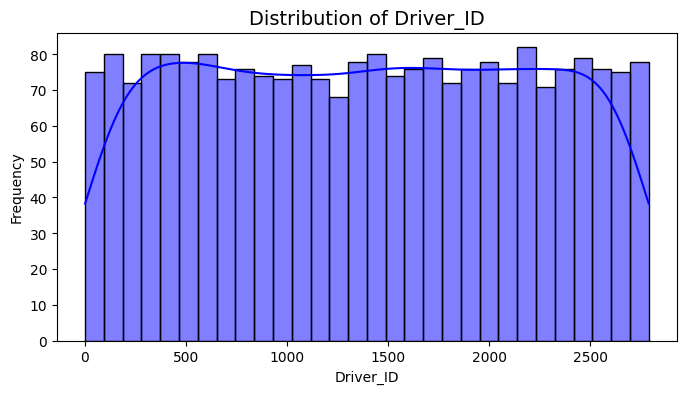

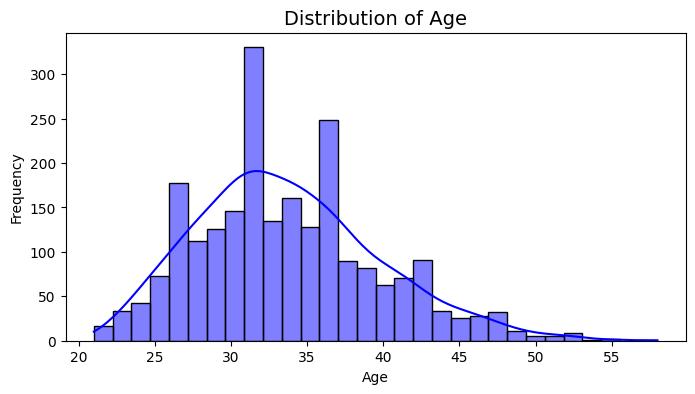

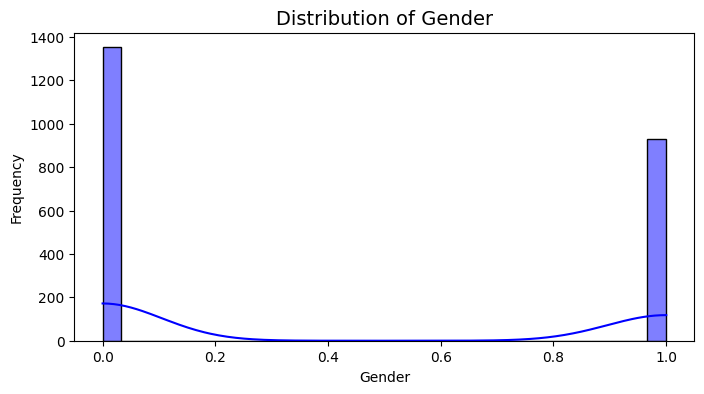

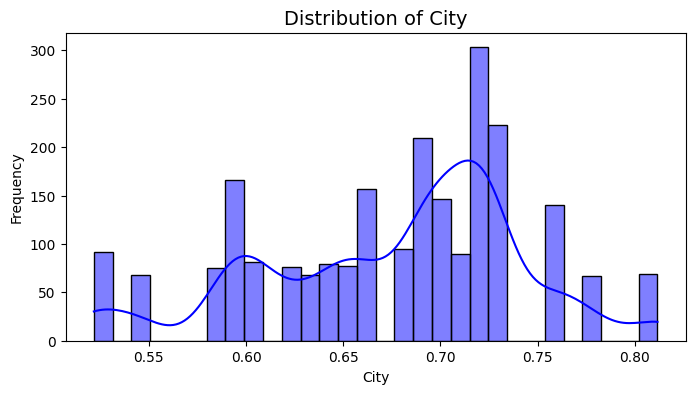

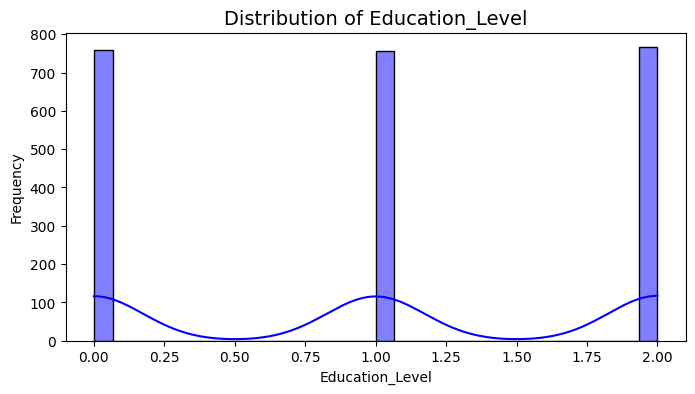

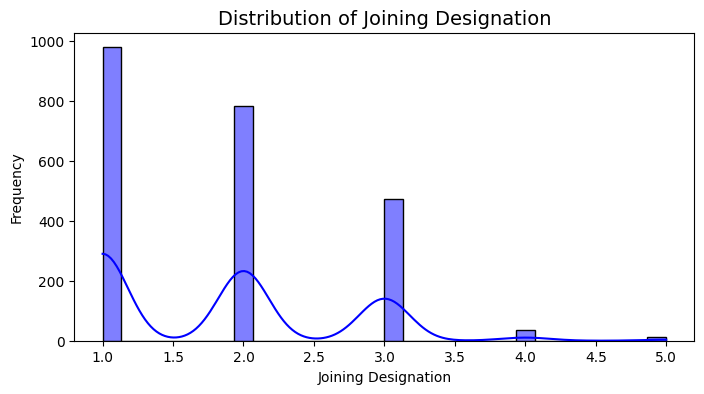

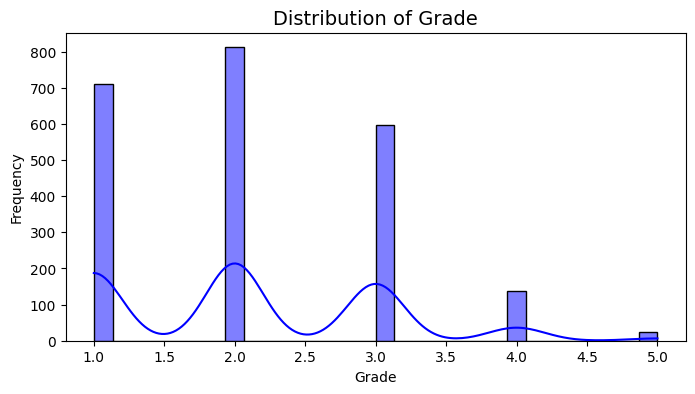

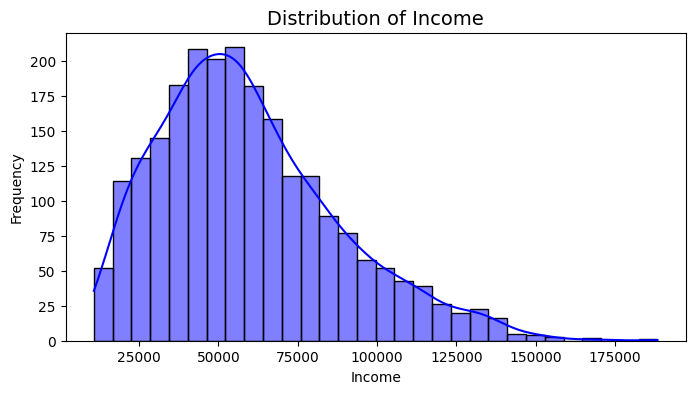

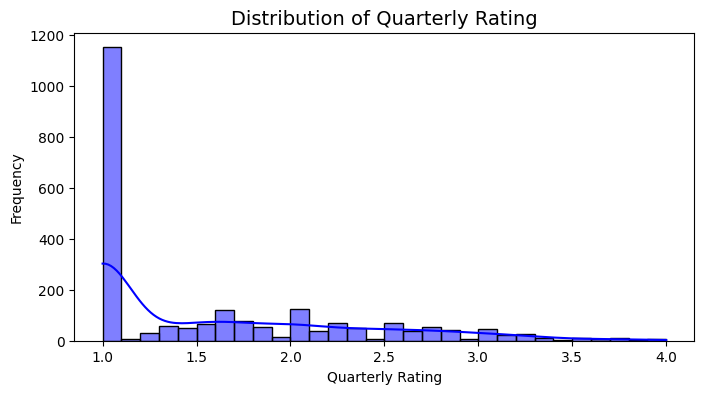

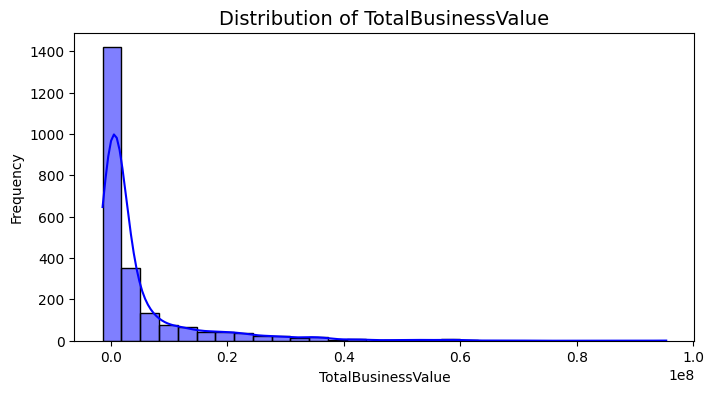

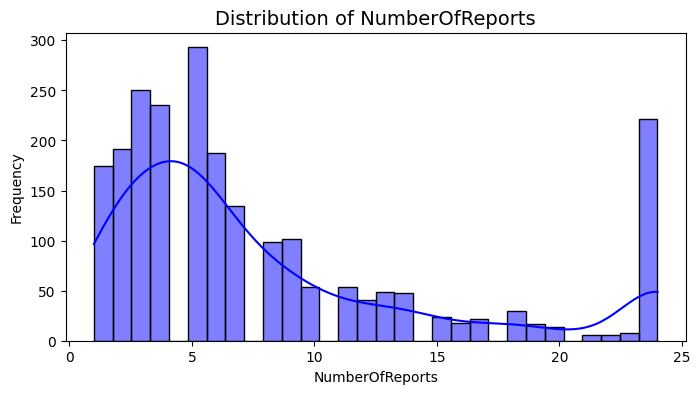

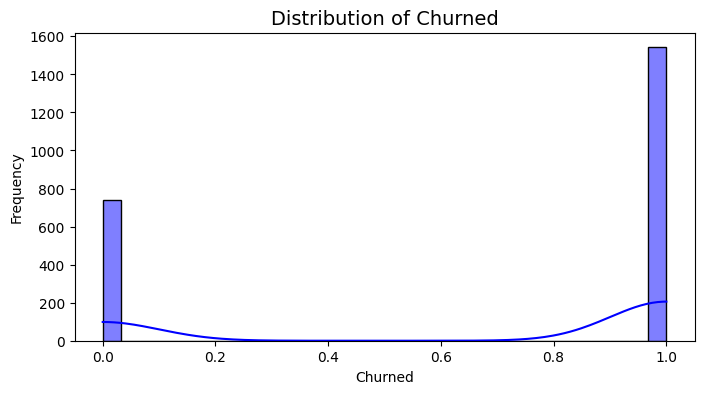

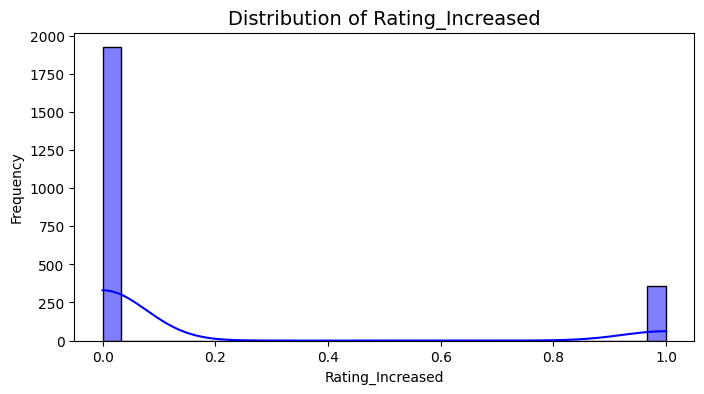

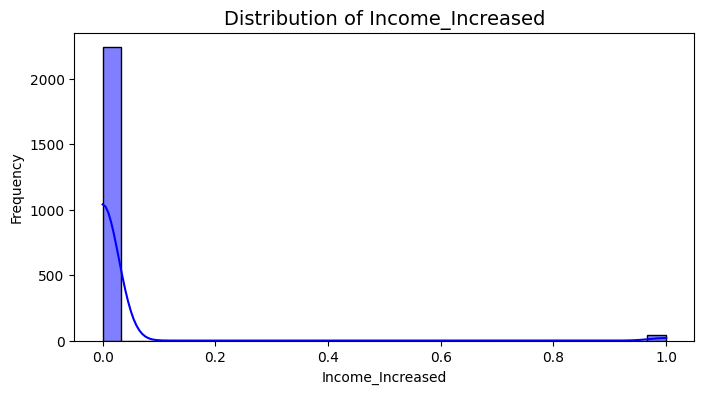

In [1883]:
def univariate_analysis(df):
    numerical_features = df.select_dtypes(include=['int64', 'float64']).columns
    # Plot histograms for numerical features
    for feature in numerical_features:
        plt.figure(figsize=(8, 4))
        sns.histplot(df[feature], kde=True, bins=30, color='blue')
        plt.title(f'Distribution of {feature}', fontsize=14)
        plt.xlabel(feature)
        plt.ylabel('Frequency')
        plt.show()
univariate_analysis(data_uniq)

## Bivariate Analysis: Count of Churned vs. Non-Churned by Education Level

Creating a count plot to visualize the relationship between education level and driver churn. The plot shows the counts of churned and non-churned drivers across different education levels, indicating that education level does not appear to significantly influence churn rates among drivers.


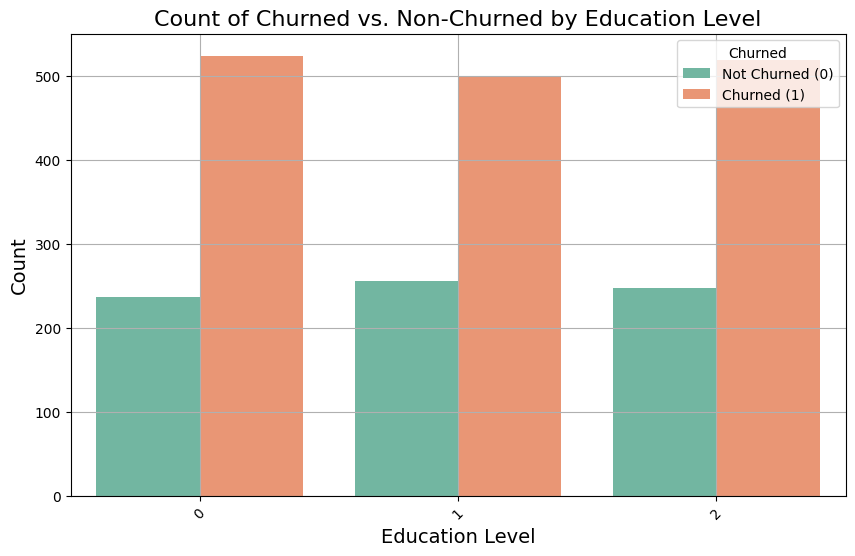

In [1884]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Education_Level', hue='Churned', data=data_uniq, palette='Set2')
plt.title('Count of Churned vs. Non-Churned by Education Level', fontsize=16)
plt.xlabel('Education Level', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend(title='Churned', loc='upper right', labels=['Not Churned (0)', 'Churned (1)'])
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.show()


## Bivariate Analysis: Average Income by Gender

Creating a bar plot to display the average income for drivers based on gender. The analysis reveals that there is no significant difference in income levels between genders, indicating that gender does influence income among drivers.


<ipython-input-1885-cdd0af64718e>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Gender', y='Income', data=income_by_gender, palette='Set2')


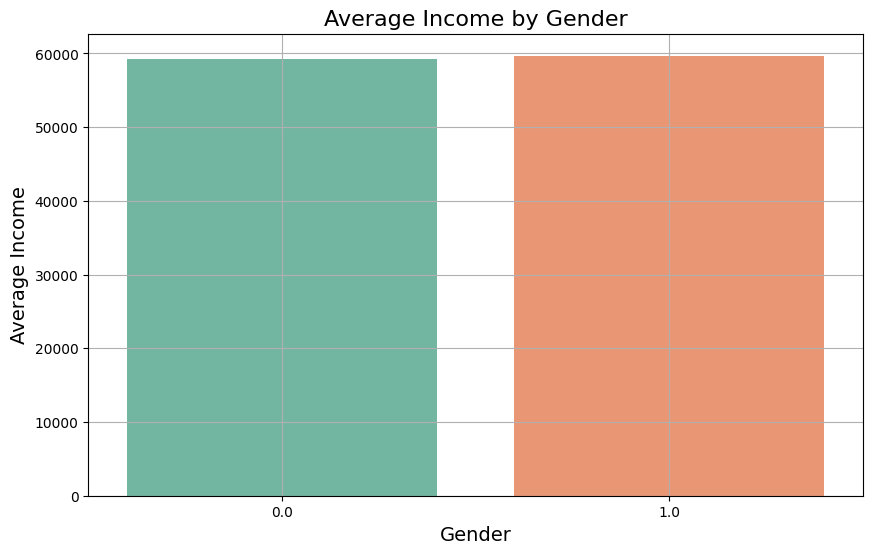

In [1885]:
income_by_gender = data_uniq.groupby('Gender')['Income'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='Gender', y='Income', data=income_by_gender, palette='Set2')
plt.title('Average Income by Gender', fontsize=16)
plt.xlabel('Gender', fontsize=14)
plt.ylabel('Average Income', fontsize=14)
plt.grid(True)
plt.show()

## Bivariate Analysis: Top 5 Quarterly Ratings by Average Income

Calculating the average income for each quarterly rating and identifying the top 5 ratings with the highest average income.

<ipython-input-1886-06648967ce18>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Quarterly Rating', y='Income', data=top_5_average_income, palette='Set2')


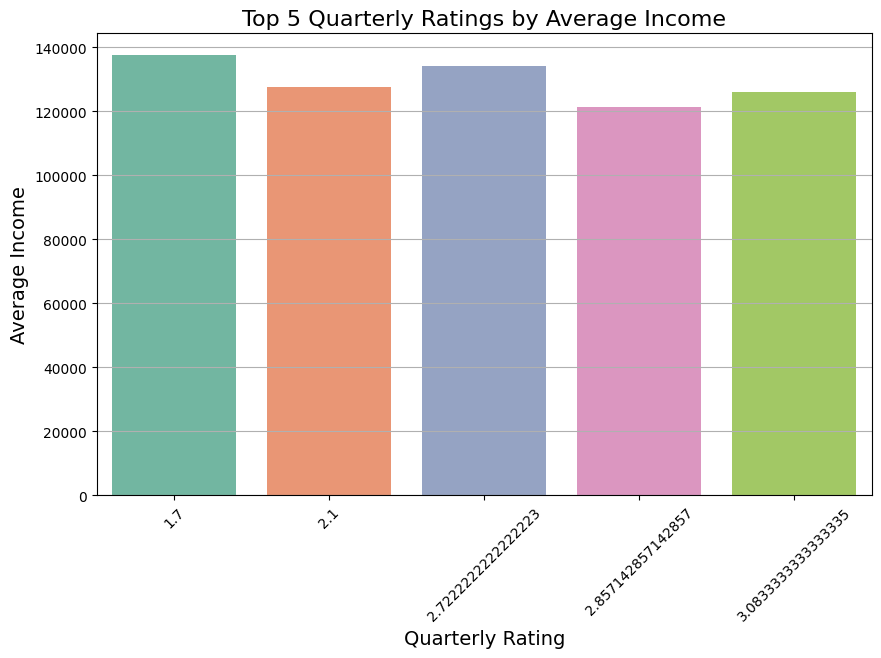

In [1886]:
# Calculating average income for each quarterly rating
average_income = data_uniq.groupby('Quarterly Rating')['Income'].mean().reset_index()

#top 5 quarterly ratings with the highest average income
top_5_average_income = average_income.nlargest(5, 'Income')

plt.figure(figsize=(10, 6))
sns.barplot(x='Quarterly Rating', y='Income', data=top_5_average_income, palette='Set2')
plt.title('Top 5 Quarterly Ratings by Average Income', fontsize=16)
plt.xlabel('Quarterly Rating', fontsize=14)
plt.ylabel('Average Income', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

## Bivariate Analysis: Average Increased Income by Churned Status

Calculating the average increased income based on churned status, this bar plot illustrates a significant difference between drivers who churned and those who did not. The results indicate that drivers who experienced an increase in income are less likely to churn, highlighting the importance of income stability in driver retention.


<ipython-input-1887-44bc045a45fc>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Churned', y='Income_Increased', data=average_income, palette='Set2')


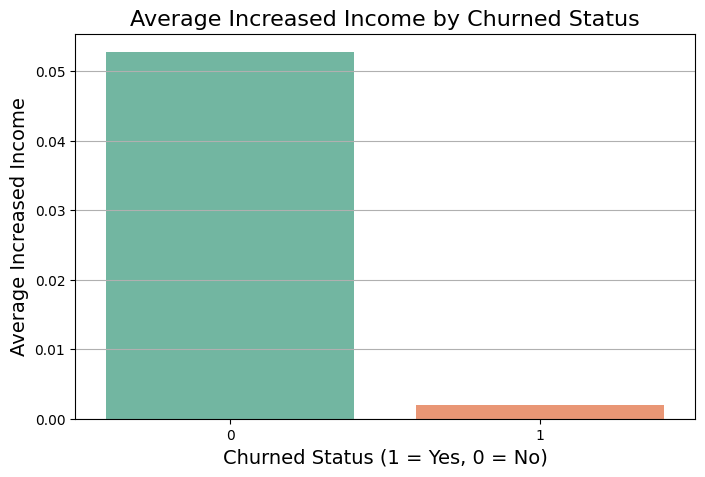

In [1887]:
# Calculate the average increased income by churned status
average_income = data_uniq.groupby('Churned')['Income_Increased'].mean().reset_index()

# Create a bar plot
plt.figure(figsize=(8, 5))
sns.barplot(x='Churned', y='Income_Increased', data=average_income, palette='Set2')
plt.title('Average Increased Income by Churned Status', fontsize=16)
plt.xlabel('Churned Status (1 = Yes, 0 = No)', fontsize=14)
plt.ylabel('Average Increased Income', fontsize=14)
plt.xticks(rotation=0)  # No rotation needed for binary categories
plt.grid(axis='y')
plt.show()


## Bivariate Analysis: Age Distribution by Churned Status

This histogram visualizes the age distribution of drivers, segmented by churned status. The plot shows distinct density patterns for churned and non-churned drivers, indicating that age may influence churn likelihood. Notably, certain age groups exhibit higher churn rates, suggesting potential areas for targeted retention strategies.


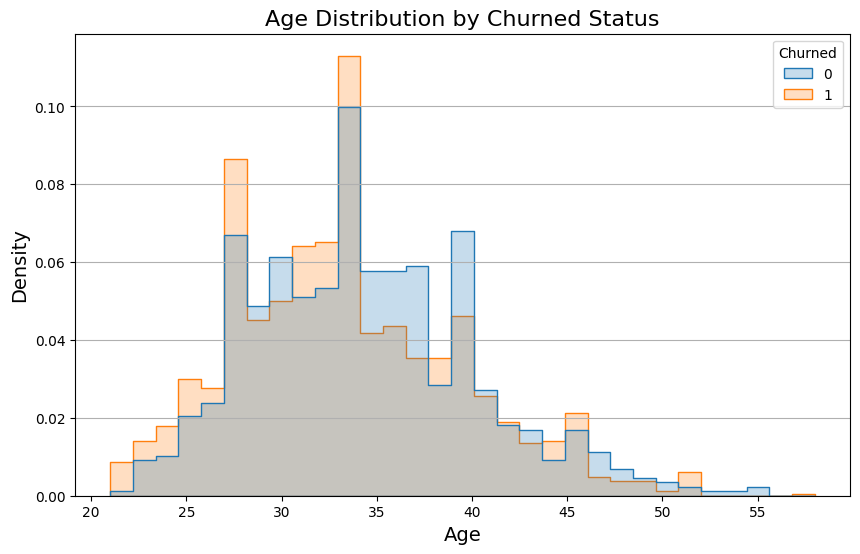

In [1888]:
plt.figure(figsize=(10, 6))
sns.histplot(data=data_uniq, x='Age', hue='Churned', element='step', stat='density', common_norm=False)
plt.title('Age Distribution by Churned Status', fontsize=16)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.grid(axis='y')
plt.show()

## Correlation Analysis: Heatmap of Correlation Matrix

The heatmap displays the correlation matrix for various features in the dataset. Notable correlations include:

- **Joining Designation and Grade**: A strong positive correlation of **0.71**, indicating that higher grades are associated with specific joining designations.
- **Total Business Value and Number of Reports**: A high correlation of **0.79**, suggesting that drivers with more reports tend to generate higher business value.
- **Number of Reports and Quarterly Rating**: This relationship also shows significant correlation, highlighting that increased reporting may contribute to higher ratings.

These insights can guide further analysis and feature selection for predictive modeling.


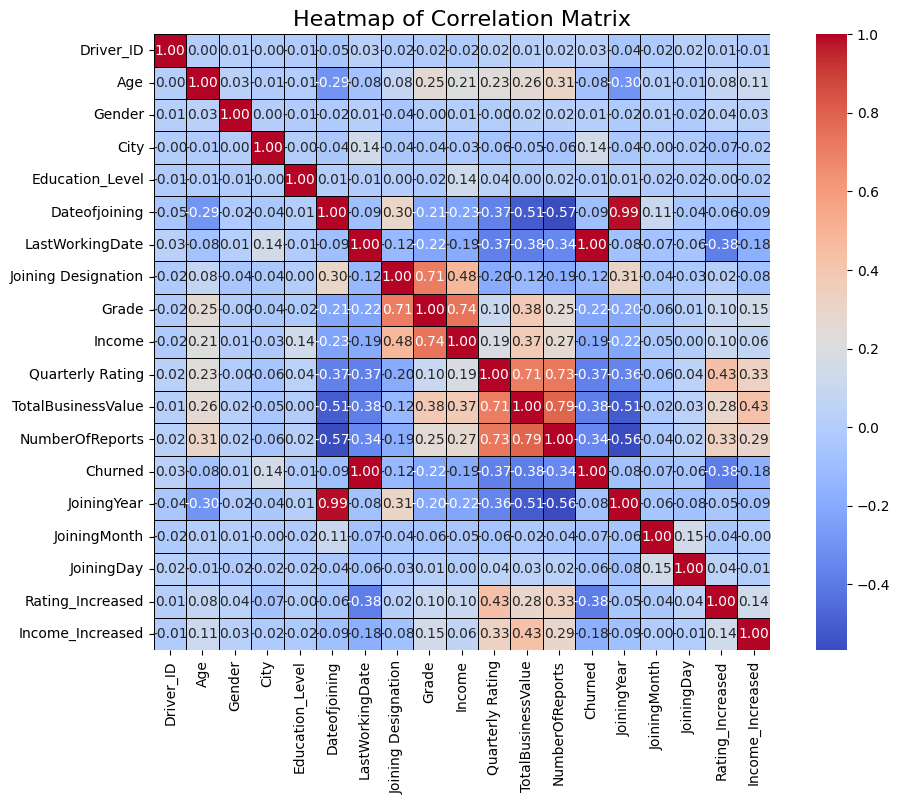

In [1889]:
correlation_matrix = data_uniq.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar=True,
            linewidths=0.5, linecolor='black')
plt.title('Heatmap of Correlation Matrix', fontsize=16)
plt.show()

## Hypothesis Testing: Impact of Age on Income

### Null and Alternative Hypothesis
- **Null Hypothesis (H0)**: Age does not significantly affect income. (There is no difference in income between younger and older individuals.)
- **Alternative Hypothesis (H1)**: Age significantly affects income. (There is a difference in income between younger and older individuals.)

### Analysis
An age grouping was created, categorizing individuals as either "Younger" (under 30) or "Older" (30 and above). The following statistical analysis was conducted:

- **T-Test Results**:
  - **T-statistic**: -8.46
  - **P-value**: \(4.88 \times 10^{-17}\)

### Conclusion
Since the P-value is significantly less than the threshold of 0.05, the null hypothesis is rejected. This indicates that age has a significant effect on income, suggesting that income levels differ between the younger and older age groups.


In [1890]:
data_uniq['Age_Group'] = np.where(data_uniq['Age'] < 30, 'Younger', 'Older')

# Grouping income by age group
younger_income = data_uniq[data_uniq['Age_Group'] == 'Younger']['Income']
older_income = data_uniq[data_uniq['Age_Group'] == 'Older']['Income']

#  T-test
t_stat, p_value = ttest_ind(younger_income, older_income)
print(f"T-statistic: {t_stat}, P-value: {p_value}")
# Final verdict
if p_value < 0.05:
    print("Verdict: Reject the null hypothesis. Age significantly affects income.")
else:
    print("Verdict: Fail to reject the null hypothesis. Age does not significantly affect income.")

T-statistic: -8.455589026793495, P-value: 4.883911350947741e-17
Verdict: Reject the null hypothesis. Age significantly affects income.


## Hypothesis Testing: Impact of Age on Churn

### Null and Alternative Hypothesis
- **Null Hypothesis (H0)**: Age does not significantly affect churn. (There is no difference in age between churned and not churned individuals.)
- **Alternative Hypothesis (H1)**: Age significantly affects churn. (There is a difference in age between churned and not churned individuals.)

### Analysis
The ages of churned and not churned individuals were compared. The following statistical analysis was conducted:

- **T-Test Results**:
  - **T-statistic**: -3.66
  - **P-value**: 0.00026

### Conclusion
Since the P-value is significantly less than the threshold of 0.05, the null hypothesis is rejected. This indicates that age significantly affects churn, suggesting that age differences exist between individuals who churn and those who do not.


In [1891]:
churned_age = data_uniq[data_uniq['Churned'] == 1]['Age']
not_churned_age = data_uniq[data_uniq['Churned'] == 0]['Age']

# T-test
t_stat, p_value = ttest_ind(churned_age, not_churned_age)
print(f"T-statistic: {t_stat}, P-value: {p_value}")
if p_value < 0.05:
    print("Verdict: Reject the null hypothesis. Age significantly affects churn.")
else:
    print("Verdict: Fail to reject the null hypothesis. Age does not significantly affect churn.")

T-statistic: -3.655923422541413, P-value: 0.00026205673560615264
Verdict: Reject the null hypothesis. Age significantly affects churn.


## Hypothesis Testing: Impact of Education Level on Churn

### Null and Alternative Hypothesis
- **Null Hypothesis (H0)**: Education level does not significantly affect churn.
- **Alternative Hypothesis (H1)**: Education level significantly affects churn.

### Analysis
A Chi-square test of independence was conducted to examine the relationship between education level and churn status. The following results were obtained:

- **Chi-square Statistic**: 1.42
- **P-value**: 0.4913
- **Degrees of Freedom**: 2
- **Expected Frequencies**:
  - Education Level 1: 246.23 (Not Churned), 513.77 (Churned)
  - Education Level 2: 244.61 (Not Churned), 510.39 (Churned)
  - Education Level 3: 248.17 (Not Churned), 517.83 (Churned)

### Conclusion
Since the P-value is greater than the significance level of 0.05, the null hypothesis is not rejected. This indicates that education level does not significantly affect churn.


In [1892]:
contingency_table = pd.crosstab(data_uniq['Education_Level'], data_uniq['Churned'])


chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-square Statistic: {chi2_stat}, P-value: {p_value}, Degrees of Freedom: {dof}")
print("Expected Frequencies:\n", expected)
if p_value < 0.05:
    print("Verdict: Reject the null hypothesis. Education level significantly affects churn.")
else:
    print("Verdict: Fail to reject the null hypothesis. Education level does not significantly affect churn.")

Chi-square Statistic: 1.4214809143976717, P-value: 0.4912802907209989, Degrees of Freedom: 2
Expected Frequencies:
 [[246.22533976 513.77466024]
 [244.60543621 510.39456379]
 [248.16922402 517.83077598]]
Verdict: Fail to reject the null hypothesis. Education level does not significantly affect churn.


## Hypothesis Testing: Impact of Income on Education Level

### Null and Alternative Hypothesis
- **Null Hypothesis (H0)**: Income does not significantly affect education level.
- **Alternative Hypothesis (H1)**: Income significantly affects education level.

### Analysis
A Chi-square test of independence was conducted to examine the relationship between education level and income. The following results were obtained:

- **Chi-square Statistic**: 4479.97
- **P-value**: 0.5310
- **Degrees of Freedom**: 4488
- **Expected Frequencies**:
  - Values are distributed uniformly across education levels.

### Conclusion
Since the P-value is greater than the significance level of 0.05, the null hypothesis is not rejected. This indicates that income does not significantly affect education level.


In [1893]:
contingency_table_income_education = pd.crosstab(data_uniq['Education_Level'], data_uniq['Income'])
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table_income_education)
print(f"Chi-square Statistic: {chi2_stat}, P-value: {p_value}, Degrees of Freedom: {dof}")
print("Expected Frequencies:\n", expected)
if p_value < 0.05:
    print("Verdict: Reject the null hypothesis. Income significantly affects education level.")
else:
    print("Verdict: Fail to reject the null hypothesis. Income does not significantly affect education level.")

Chi-square Statistic: 4479.967200758931, P-value: 0.5310060696825166, Degrees of Freedom: 4488
Expected Frequencies:
 [[0.3331872  0.3331872  0.3331872  ... 0.3331872  0.3331872  0.3331872 ]
 [0.33099518 0.33099518 0.33099518 ... 0.33099518 0.33099518 0.33099518]
 [0.33581762 0.33581762 0.33581762 ... 0.33581762 0.33581762 0.33581762]]
Verdict: Fail to reject the null hypothesis. Income does not significantly affect education level.


In [1894]:
data_uniq.drop(columns=['Dateofjoining','LastWorkingDate','Age_Group'],inplace=True)

## SMOTE Implementation for Addressing Class Imbalance

### Overview
To address the class imbalance in the dataset, SMOTE (Synthetic Minority Over-sampling Technique) is applied to generate synthetic samples for the minority class.

### Data Preparation
- The value counts of the `Churned` variable are assessed before resampling.
- Features (`X`) are separated from the target variable (`y`).

### Resampling Process
SMOTE is employed to balance the classes:

- **Original Class Distribution**:
  - Churned (1): 1542
  - Not Churned (0): 739

After applying SMOTE, the resampled dataset yields equal counts for both classes:

- **Resampled Class Distribution**:
  - Churned (1): 1542
  - Not Churned (0): 1542


In [1895]:
final_test_sample.drop(columns=['Dateofjoining','LastWorkingDate'],inplace=True)

In [1896]:
data_uniq['Churned'].value_counts()

,count
Churned,
1,1542
0,739


In [1897]:
X = data_uniq.drop(columns=['Churned'])
y = data_uniq['Churned']

In [1898]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

data_resampled = pd.DataFrame(X_resampled, columns=X.columns)
data_resampled['Churned'] = y_resampled

In [1899]:
data_resampled['Churned'].value_counts()

,count
Churned,
1,1542
0,1542


In [1900]:
X = data_resampled.drop(columns=['Churned'])
y = data_resampled['Churned']

# Splitting the data i
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [1901]:
X_test = final_test_sample.drop(columns=['Churned'])
y_test = final_test_sample['Churned']

In [1902]:
print(X_train.shape, y_train.shape,X_val.shape,y_val.shape,X_test.shape,y_test.shape)

(2467, 16) (2467,) (617, 16) (617,) (100, 16) (100,)


## Feature Scaling Using Min-Max Scaler

### Overview
Min-Max scaling standardizes features to a range of 0 to 1, ensuring equal contribution during model training.

### Scaling Process
1. **Fitting the Scaler**: The `MinMaxScaler` is fitted to `X_train`.
2. **Transforming Data**:
   - `X_train` is scaled.
   - `X_val` and `X_test` are transformed with the same scaler.

### Results
- Shapes of the scaled datasets are displayed to confirm the transformations.


In [1903]:
# scaler = MinMaxScaler()
# X_train = scaler.fit_transform(X_train)

# # Transform the validation and test data
# X_val = scaler.transform(X_val)
# X_test = scaler.transform(X_test)

# X_train = pd.DataFrame(X_train, columns=X.columns)
# X_val = pd.DataFrame(X_val, columns=X.columns)
# X_test = pd.DataFrame(X_test, columns=X.columns)
# print(X_train.shape, X_val.shape, X_test.shape)

In [1904]:
X_train.columns = X_train.columns.str.replace(' ', '_')
X_test.columns = X_test.columns.str.replace(' ', '_')
X_val.columns = X_val.columns.str.replace(' ', '_')

## Decision Tree Classifier Initialization and Training

### Overview
A Decision Tree classifier is initialized and trained to predict churn.

### Model Setup
- **Classifier**: `DecisionTreeClassifier` with `criterion='entropy'`.

### Training the Model
- The model is fitted on the training data (`X_train`, `y_train`).

### Accuracy Results
- **Training Accuracy**: 1.00 (Indicating Overfitting)
- **Validation Accuracy**: 0.89


In [1905]:
# Initializing  Decision Tree classifier
clf = DecisionTreeClassifier(criterion='entropy')

# Fiting model on the training data
clf.fit(X_train, y_train)

print(f"Train Accuracy: {clf.score(X_train, y_train):.2f}")
print(f"Train Accuracy: {clf.score(X_val, y_val):.2f}")

Train Accuracy: 1.00
Train Accuracy: 0.90


# K-Fold Cross-Validation Results for Decision Tree Depths

## Overview
This section presents the accuracy results of a Decision Tree classifier evaluated using K-Fold cross-validation for various maximum depths.

## Results Summary

| Depth | Train Accuracy Mean (%) | Validation Accuracy Mean (%) | Train Accuracy Std (%) | Validation Accuracy Std (%) |
|-------|-------------------------|-----------------------------|------------------------|-----------------------------|
| 3     | 81.56                   | 80.74                       | 1.37                   | 1.94                        |
| 4     | 85.30                   | 84.03                       | 0.59                   | 2.53                        |
| 5     | 87.80                   | 85.20                       | 0.75                   | 1.79                        |
| 67    | 100.00                  | 86.91                       | 0.00                   | 1.80                        |
| 9     | 96.50                   | 87.15                       | 0.31                   | 1.83                        |
| 11    | 98.86                   | 86.99                       | 0.24                   | 1.56                        |
| 13    | 99.78                   | 87.03                       | 0.12                   | 1.80                        |
| 15    | 99.97                   | 86.87                       | 0.06                   | 1.74                        |

## Key Observations
- The model demonstrates a high training accuracy, especially at greater depths, indicating potential overfitting.
- The validation accuracy shows a more stable performance across depths, particularly at depths of 4 to 9.
- Depths beyond 4 show diminishing returns in validation accuracy, with notable overfitting at depth 67.

This analysis helps in selecting the optimal depth for the Decision Tree model, balancing complexity and generalization.


In [1906]:
kfold = KFold(n_splits=10)

depths = [3,4,5,67,9,11,13,15]

for depth in depths:
    tree_clf = DecisionTreeClassifier(random_state=7, max_depth=depth)

    cv_acc_results = cross_validate(tree_clf, X_train, y_train, cv = kfold, scoring = 'accuracy', return_train_score = True)

    print(f"K-Fold for depth:{depth} Accuracy Mean: Train: {cv_acc_results['train_score'].mean()*100} Validation: {cv_acc_results['test_score'].mean()*100}")
    print(f"K-Fold for depth: {depth} Accuracy Std: Train: {cv_acc_results['train_score'].std()*100} Validation: {cv_acc_results['test_score'].std()*100}")
    print('***************')

K-Fold for depth:3 Accuracy Mean: Train: 81.56095785114245 Validation: 80.74437971100359
K-Fold for depth: 3 Accuracy Std: Train: 1.3667266816389987 Validation: 1.9365120577966763
***************
K-Fold for depth:4 Accuracy Mean: Train: 85.30372042461192 Validation: 84.02817550442711
K-Fold for depth: 4 Accuracy Std: Train: 0.5871862416483122 Validation: 2.5289013912426705
***************
K-Fold for depth:5 Accuracy Mean: Train: 87.8033776685285 Validation: 85.20341660906489
K-Fold for depth: 5 Accuracy Std: Train: 0.7520043248941999 Validation: 1.7911454500571435
***************
K-Fold for depth:67 Accuracy Mean: Train: 100.0 Validation: 86.90612553898818
K-Fold for depth: 67 Accuracy Std: Train: 0.0 Validation: 1.803930471647128
***************
K-Fold for depth:9 Accuracy Mean: Train: 96.5004522757787 Validation: 87.14788848293342
K-Fold for depth: 9 Accuracy Std: Train: 0.31034832528603706 Validation: 1.833151900495749
***************
K-Fold for depth:11 Accuracy Mean: Train: 98.864

# Decision Tree Classifier Training and Visualization

A Decision Tree classifier was trained with a maximum depth of 4, selecting key parameters. The resulting tree has been visualized to illustrate the decision-making process.



In [1907]:
tree_clf = DecisionTreeClassifier(random_state=7, max_depth=4)
tree_clf=tree_clf.fit(X_train, y_train)
pred = tree_clf.predict(X_test)

In [1908]:
from IPython.display import Image
from six import StringIO
from sklearn.tree import export_graphviz
import pydot

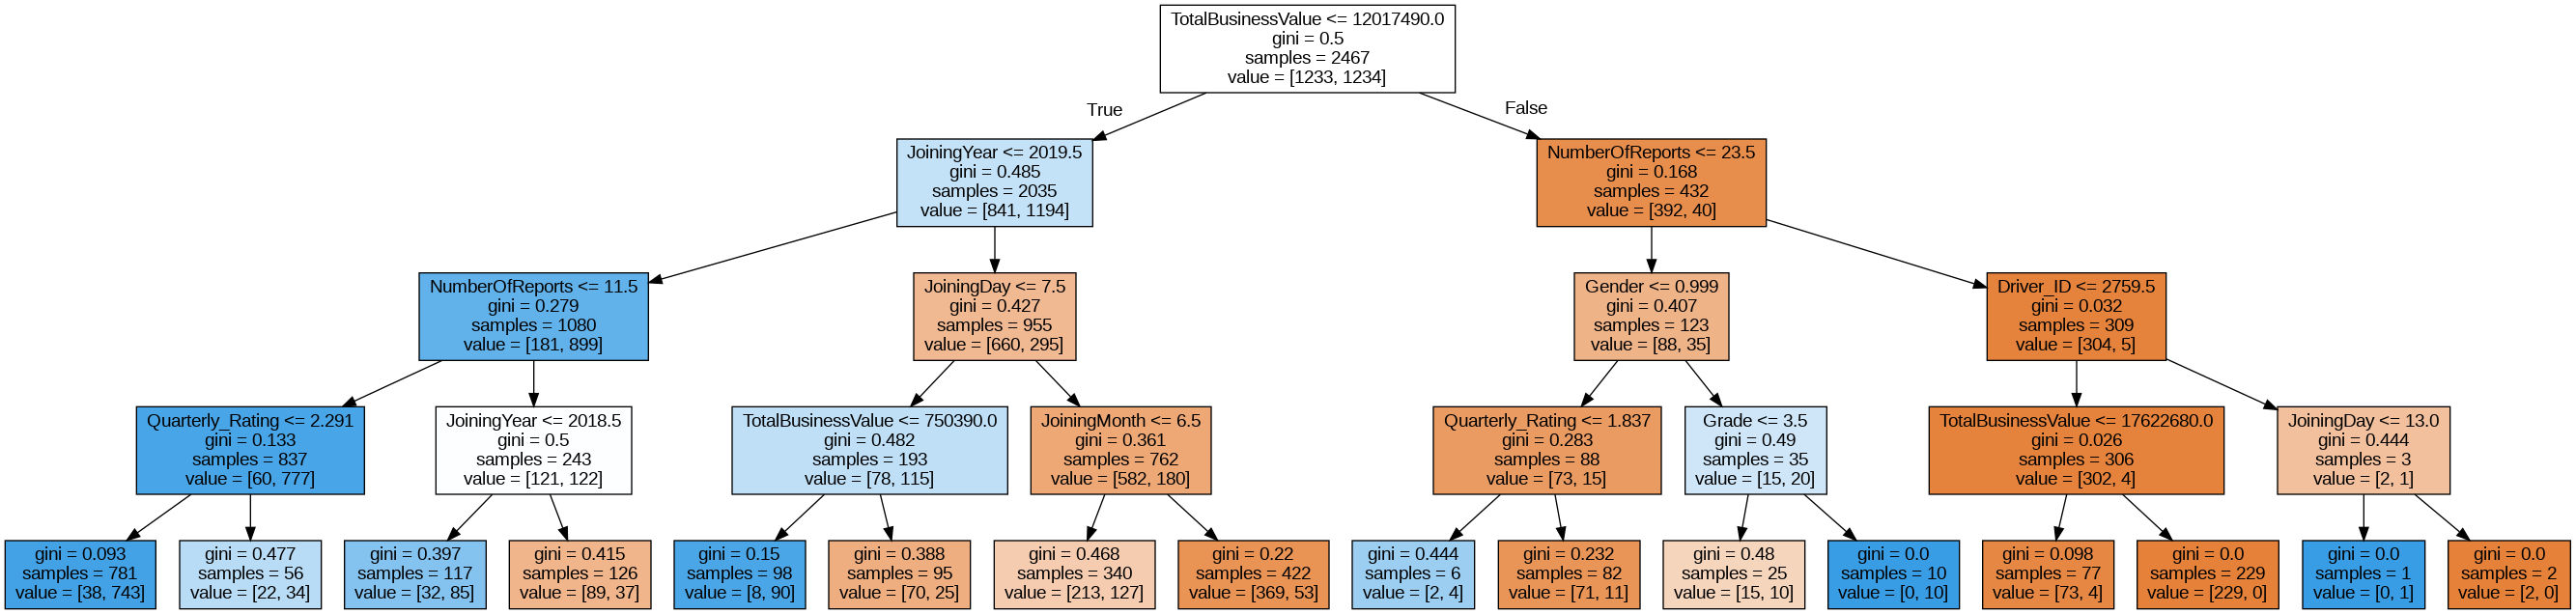

In [1909]:
features = list(X_train.columns)
dot_data = StringIO()
export_graphviz(tree_clf, out_file=dot_data, feature_names=features, filled=True)
graph = pydot.graph_from_dot_data(dot_data.getvalue())
Image(graph[0].create_png())



# Confusion Matrix Visualization

A confusion matrix was generated to evaluate the performance of the trained Decision Tree classifier. The matrix visualizes the true positive, false positive, true negative, and false negative predictions.

The results are as follows:
- True Positives (TP): 54 (Correctly predicted churned)
- False Positives (FP): 3 (Incorrectly predicted as churned)
- True Negatives (TN): 20 (Correctly predicted not churned)
- False Negatives (FN): 23 (Incorrectly predicted as not churned)

This indicates that the model is relatively effective, but there is some room for improvement, especially in reducing false negatives.


Text(0.5, 23.52222222222222, 'Predicted label')

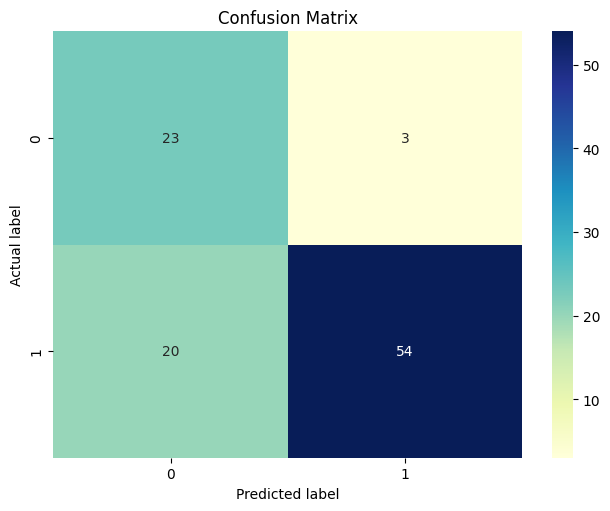

In [1910]:
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(y_test, pred)
fig, ax = plt.subplots()


sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')

plt.tight_layout()
plt.title('Confusion Matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# Feature Importance Analysis

The feature importance analysis reveals the top three features influencing the Decision Tree model:

1. **JoiningYear**: 0.434884
2. **TotalBusinessValue**: 0.312199
3. **NumberOfReports**: 0.117367

These features significantly contribute to the model's predictions, indicating their relevance in assessing churn.


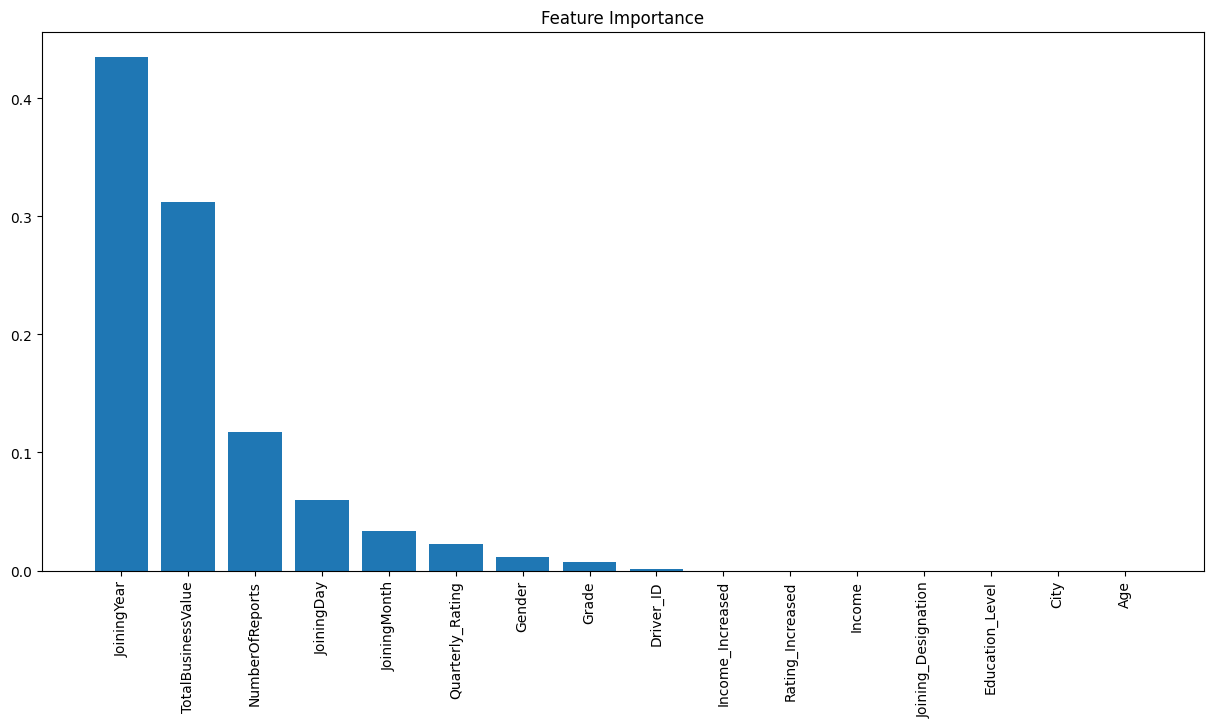

In [1911]:
importances = tree_clf.feature_importances_
indices = np.argsort(importances)[::-1]
names = [X_train.columns[i] for i in indices]

plt.figure(figsize=(15, 7))
plt.title("Feature Importance")
plt.bar(range(X_train.shape[1]), importances[indices])
plt.xticks(range(X_train.shape[1]), names, rotation=90)
plt.show()

In [1912]:
df_param_coeff = pd.DataFrame(columns=['Feature', 'Coefficient'])
for i in range(len(list(X_train.columns))):
    feat = X_train.columns[i]
    coeff = importances[i]
    df_param_coeff.loc[i] = (feat, coeff)
df_param_coeff.sort_values(by='Coefficient', ascending=False, inplace=True)
df_param_coeff = df_param_coeff.reset_index(drop=True)
df_param_coeff.head(10)

,Feature,Coefficient
0,JoiningYear,0.434884
1,TotalBusinessValue,0.312199
2,NumberOfReports,0.117367
3,JoiningDay,0.059571
4,JoiningMonth,0.033499
5,Quarterly_Rating,0.022505
6,Gender,0.011652
7,Grade,0.007442
8,Driver_ID,0.000882
9,Age,0.000000


# Random Forest Model Evaluation

The Random Forest classifier was evaluated using 10-fold cross-validation. The results are as follows:

- **K-Fold Accuracy Mean**:
  - Train: 87.64%
  - Validation: 85.93%

- **K-Fold Accuracy Standard Deviation**:
  - Train: 0.50%
  - Validation: 2.13%

These results indicate a strong performance of the model, with minimal variance between training and validation accuracies.


In [1913]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(random_state=7, max_depth=4, n_estimators=100)

In [1914]:
from sklearn.model_selection import KFold, cross_validate

kfold = KFold(n_splits=10)
cv_acc_results = cross_validate(rf_clf, X_train, y_train, cv=kfold, scoring='accuracy', return_train_score=True)

print(f"K-Fold Accuracy Mean: \n Train: {cv_acc_results['train_score'].mean()*100:.2f} \n Validation: {cv_acc_results['test_score'].mean()*100:.2f}")
print(f"K-Fold Accuracy Std: \n Train: {cv_acc_results['train_score'].std()*100:.2f}, \n Validation: {cv_acc_results['test_score'].std()*100:.2f}")

K-Fold Accuracy Mean: 
 Train: 87.64 
 Validation: 85.93
K-Fold Accuracy Std: 
 Train: 0.50, 
 Validation: 2.13


# Hyperparameter Tuning with Grid Search

Using Grid Search, the hyperparameters for the Random Forest model were optimized. The best parameters found are:

- **Bootstrap**: True
- **Criterion**: Entropy
- **Max Depth**: 10
- **Max Features**: 10
- **Number of Estimators**: 300

The best cross-validated score achieved is **90.64%**, indicating a significant improvement in model performance with these parameters.


In [1915]:
params = {
          'n_estimators' : [100,200,300,400],
          'max_depth' : [3,5,10],
          'criterion' : ['gini', 'entropy'],
          'bootstrap' : [True, False],
          'max_features' : [8,9,10]
         }

In [1916]:
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(estimator = RandomForestClassifier(),
                    param_grid = params,
                    scoring = 'accuracy',
                    cv = 3,
                    n_jobs=-1
                    )
grid.fit(X_train, y_train)

print("Best params: ", grid.best_params_)
print("Best score: ", grid.best_score_)

Best params:  {'bootstrap': True, 'criterion': 'gini', 'max_depth': 10, 'max_features': 10, 'n_estimators': 200}
Best score:  0.9051464436383417


# Model Evaluation with Random Forest

The Random Forest model was evaluated using 10-fold cross-validation. The results are as follows:

- **K-Fold Accuracy Mean**:
  - Train: **98.69%**
  - Validation: **91.00%**

- **K-Fold Accuracy Std**:
  - Train: **0.11%**
  - Validation: **1.93%**

- **K-Fold Recall Mean**:
  - Train: **98.72%**
  - Validation: **88.52%**

- **K-Fold Recall Std**:
  - Train: **0.23%**
  - Validation: **3.79%**

These metrics indicate a strong performance of the model on both training and validation sets, with high accuracy and recall rates.


In [1917]:
clf2 = RandomForestClassifier(random_state=7, bootstrap=True, criterion='entropy',
                              max_depth=10, max_features=9, n_estimators=400)

kfold = KFold(n_splits=10)
cv_results = cross_validate(clf2, X_train, y_train, cv=kfold, scoring=['accuracy','recall'], return_train_score=True)

print(f"K-Fold Accuracy Mean: \n Train: {cv_results['train_accuracy'].mean()*100:.3f} \n Validation: {cv_results['test_accuracy'].mean()*100:.3f}")
print(f"K-Fold Accuracy Std: \n Train: {cv_results['train_accuracy'].std()*100:.3f}, \n Validation: {cv_results['test_accuracy'].std()*100:.3f}")

#  Recall Mean and Std for Train and Validation sets
print(f"K-Fold Recall Mean: \n Train: {cv_results['train_recall'].mean()*100:.3f} \n Validation: {cv_results['test_recall'].mean()*100:.3f}")
print(f"K-Fold Recall Std: \n Train: {cv_results['train_recall'].std()*100:.3f}, \n Validation: {cv_results['test_recall'].std()*100:.3f}")

K-Fold Accuracy Mean: 
 Train: 98.694 
 Validation: 91.000
K-Fold Accuracy Std: 
 Train: 0.114, 
 Validation: 1.926
K-Fold Recall Mean: 
 Train: 98.721 
 Validation: 88.517
K-Fold Recall Std: 
 Train: 0.225, 
 Validation: 3.790


# ROC Curve Analysis for Random Forest Model

The ROC curve illustrates the performance of the Random Forest model in distinguishing between the classes. The model was trained and predictions were made for the positive class (Churned == 1).

The Area Under the Curve (AUC) score obtained is **0.97**, indicating:

- **AUC Score Interpretation**:
  - An AUC of **0.97** demonstrates excellent model performance, suggesting that the model can effectively distinguish between churned and non-churned customers.
  
The plotted ROC curve shows the trade-off between the false positive rate and the true positive rate, with the curve being close to the top left corner, indicating strong predictive capability.



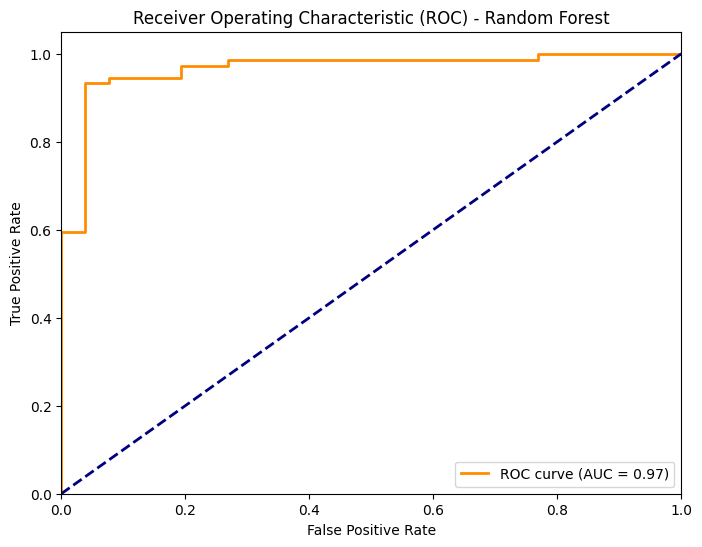

In [1918]:
from sklearn.metrics import roc_curve, roc_auc_score

clf2.fit(X_train, y_train)

# Predicting probabilities for the positive class (Churned == 1)
y_prob = clf2.predict_proba(X_test)[:, 1]

#  ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

# Ploting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Random Forest')
plt.legend(loc='lower right')
plt.show()

# Precision-Recall Curve Analysis for Random Forest Model

The Precision-Recall curve provides insight into the model's performance with respect to precision and recall for the positive class (Churned == 1).

The Average Precision (AP) score obtained is **0.99**, indicating:

- **AP Score Interpretation**:
  - An AP score of **0.99** signifies outstanding performance, suggesting that the model maintains high precision even at high levels of recall.

The plotted Precision-Recall curve illustrates the trade-off between precision and recall, with a curve close to the top right corner, indicating that the model is highly effective in identifying churned customers while minimizing false positives.


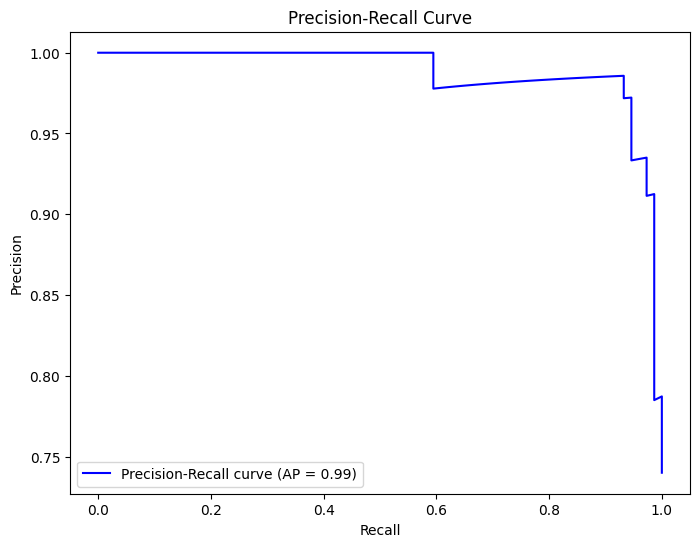

In [1920]:
from sklearn.metrics import precision_recall_curve, average_precision_score
y_prob = clf2.predict_proba(X_test)[:, 1]  # Probability for the positive class (churned)
# Computing precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
average_precision = average_precision_score(y_test, y_prob)
# Ploting Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Precision-Recall curve (AP = {average_precision:.2f})', color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

## Randomized Search Results for Gradient Boosting Classifier

The following results were obtained from the hyperparameter tuning of the Gradient Boosting Classifier using Randomized Search:

1. **Best Parameters**:  
   - **n_estimators**: 200  
   - **max_leaf_nodes**: 80  
   - **max_depth**: 5  
   - **learning_rate**: 0.3  
   - **Mean Score**: 0.9120  
   - **Rank**: 1

2. **Additional Notable Results**:
   - **Parameters**: {'n_estimators': 150, 'max_leaf_nodes': 40, 'max_depth': 4, 'learning_rate': 0.2}  
     **Mean Score**: 0.9112  
     **Rank**: 2  
     
   - **Parameters**: {'n_estimators': 200, 'max_leaf_nodes': 80, 'max_depth': 5, 'learning_rate': 0.2}  
     **Mean Score**: 0.9112  
     **Rank**: 3  

   - **Parameters**: {'n_estimators': 200, 'max_leaf_nodes': 20, 'max_depth': 5, 'learning_rate': 0.2}  
     **Mean Score**: 0.9108  
     **Rank**: 4  

These results indicate that increasing the number of estimators and adjusting the learning rate can significantly enhance model performance. The best parameter combination achieved an impressive mean accuracy score.


In [1921]:
params = {
    "n_estimators": [50,100,150,200],
    "max_depth" : [3, 4, 5, 7],
    "max_leaf_nodes" : [20, 40, 80],
    "learning_rate": [0.1, 0.2, 0.3]
}
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.model_selection import RandomizedSearchCV

gbc = GBC()
clf = RandomizedSearchCV(gbc, params, scoring = "accuracy", cv=3, n_jobs = -1, verbose = 1)

clf.fit(X_train, y_train)

res = clf.cv_results_

for i in range(len(res["params"])):
  print(f"Parameters:{res['params'][i]} Mean_score: {res['mean_test_score'][i]} Rank: {res['rank_test_score'][i]}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Parameters:{'n_estimators': 200, 'max_leaf_nodes': 40, 'max_depth': 7, 'learning_rate': 0.3} Mean_score: 0.9112276905156791 Rank: 2
Parameters:{'n_estimators': 150, 'max_leaf_nodes': 20, 'max_depth': 5, 'learning_rate': 0.1} Mean_score: 0.9087941077635183 Rank: 8
Parameters:{'n_estimators': 150, 'max_leaf_nodes': 20, 'max_depth': 4, 'learning_rate': 0.1} Mean_score: 0.9092025791345532 Rank: 7
Parameters:{'n_estimators': 150, 'max_leaf_nodes': 80, 'max_depth': 5, 'learning_rate': 0.1} Mean_score: 0.9104171532353987 Rank: 4
Parameters:{'n_estimators': 150, 'max_leaf_nodes': 40, 'max_depth': 3, 'learning_rate': 0.3} Mean_score: 0.9083930273099328 Rank: 9
Parameters:{'n_estimators': 150, 'max_leaf_nodes': 80, 'max_depth': 5, 'learning_rate': 0.3} Mean_score: 0.9096036595881386 Rank: 6
Parameters:{'n_estimators': 200, 'max_leaf_nodes': 80, 'max_depth': 4, 'learning_rate': 0.1} Mean_score: 0.9116341909753941 Rank: 1
Parameters:{'n_

## Gradient Boosting Classifier Results

The best estimator from the Randomized Search for the Gradient Boosting Classifier is as follows:

- **Model**: `GradientBoostingClassifier`
  - **Learning Rate**: 0.3
  - **Max Depth**: 5
  - **Max Leaf Nodes**: 80
  - **Number of Estimators**: 200

### Model Performance:
- **Accuracy**: 0.96
- **Recall**: 0.973

These results demonstrate the model's strong performance, particularly in its ability to correctly identify positive instances, as indicated by the high recall score.


In [1922]:
from sklearn.metrics import recall_score

print(clf.best_estimator_)

gbc = clf.best_estimator_
gbc.fit(X_train, y_train)

print("Model acc",gbc.score(X_test, y_test))

y_pred = gbc.predict(X_test)

recall = recall_score(y_test, y_pred)
print("Recall:", recall)

GradientBoostingClassifier(max_depth=4, max_leaf_nodes=80, n_estimators=200)
Model acc 0.94
Recall: 0.9594594594594594


## LightGBM Randomized Search Results

The best parameters found for the LightGBM classifier through Randomized Search are as follows:

- **Subsample**: 0.7
- **Objective**: binary
- **Metric**: binary_logloss
- **Max Depth**: 6
- **Learning Rate**: 0.5
- **Colsample Bytree**: 0.5
- **Boosting Type**: gbdt

### Model Performance:
- **Accuracy**: 0.93
- **Recall**: 0.95

### Precision-Recall Curve
After fitting the model and predicting probabilities, the Precision-Recall curve was plotted to evaluate the model's performance.

### Best Threshold
To optimize the classification, the best threshold based on the highest F1 score was calculated:

- **Best Threshold**: (value will be printed from the code)

This analysis indicates the effectiveness of the LightGBM model for the binary classification task, achieving a high recall and good overall accuracy.


In [1923]:
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV

gridParams = {
    'learning_rate': [0.1, 0.3, 0.5],
    'boosting_type': ['gbdt'],
    'objective': ['binary'],  # Binary classification
    'max_depth': [5, 6, 7, 8],
    'colsample_bytree': [0.5, 0.7],
    'subsample': [0.5, 0.7],
    'metric': ['binary_logloss'],  # Use a binary classification metric
}

clf = lgb.LGBMClassifier()

# Performing Randomized Search
random_cv = RandomizedSearchCV(clf, gridParams, verbose=3, cv=3, n_jobs=-1, n_iter=10)

# Fit the model
random_cv.fit(X_train, y_train)

# Accessing the cv_results_
res = random_cv.cv_results_

# Printing the results
for i in range(len(res["params"])):
    print(f"Parameters: {res['params'][i]} Mean Score: {res['mean_test_score'][i]} Rank: {res['rank_test_score'][i]}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[LightGBM] [Info] Number of positive: 1234, number of negative: 1233
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000334 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1870
[LightGBM] [Info] Number of data points in the train set: 2467, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500203 -> initscore=0.000811
[LightGBM] [Info] Start training from score 0.000811
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

## LightGBM Model Evaluation

After training the LightGBM classifier with the optimized parameters, the following metrics were obtained:

- **Accuracy**: 0.93
- **Recall**: 0.95

These results indicate that the model performs well in terms of both overall accuracy and the ability to correctly identify positive cases. The high recall suggests that the model is effective at minimizing false negatives, which is critical in scenarios where identifying the positive class is essential.


In [1924]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, recall_score

# Best parameters from Randomized Search
best_params = {
    'learning_rate': 0.1,
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'max_depth': 7,
    'colsample_bytree': 0.7,
    'subsample': 0.5,
    'metric': 'binary_logloss'
}

# Initializing  LightGBM classifier with best parameters
clf_best = lgb.LGBMClassifier(**best_params)

# Fit the model
clf_best.fit(X_train, y_train)

# Predicting on the test set
y_pred = clf_best.predict(X_test)

# Calculating accuracy and recall
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Recall: {recall:.2f}")

[LightGBM] [Info] Number of positive: 1234, number of negative: 1233
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000338 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1870
[LightGBM] [Info] Number of data points in the train set: 2467, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500203 -> initscore=0.000811
[LightGBM] [Info] Start training from score 0.000811
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

## Precision-Recall Curve Analysis

The Precision-Recall curve was plotted to evaluate the trade-off between precision and recall for different probability thresholds. The analysis yielded the following key points:

- **Best Threshold**: 0.39

This threshold represents the point where the F1 score, which balances precision and recall, is maximized. Using this threshold can help improve the model's performance, especially in scenarios where the cost of false positives and false negatives varies.


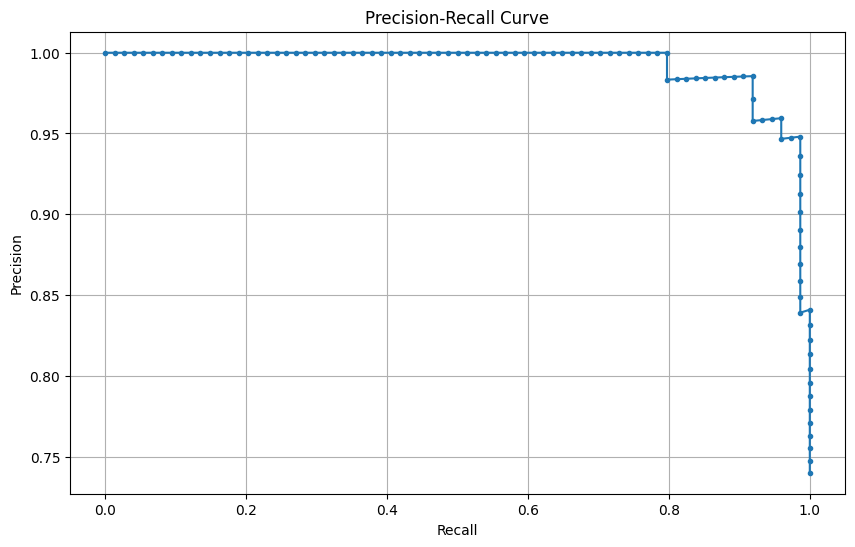

Best Threshold: 0.39


In [1926]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

y_scores = clf_best.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Ploting precision-recall curve
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid()
plt.show()

# Finding the best threshold based on the highest F1 score
f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold_index = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_index]

print(f"Best Threshold: {best_threshold:.2f}")

# Confusion Matrix Analysis for Classification Model

**Overview:**
The confusion matrix is a fundamental tool for evaluating the performance of a classification model. It provides insight into how well the model predicts each class by summarizing the counts of true positive, true negative, false positive, and false negative predictions.

**Results:**
- **True Positives (TP):** 23 instances correctly predicted as class 1 (positive).
- **True Negatives (TN):** 70 instances correctly predicted as class 0 (negative).
- **False Positives (FP):** 3 instances incorrectly predicted as class 1.
- **False Negatives (FN):** 4 instances incorrectly predicted as class 0.

**Interpretation:**
This confusion matrix indicates strong model performance, with high accuracy in distinguishing between classes. The low counts of false positives and false negatives suggest that the model is effectively identifying true cases of the positive class while minimizing misclassifications.



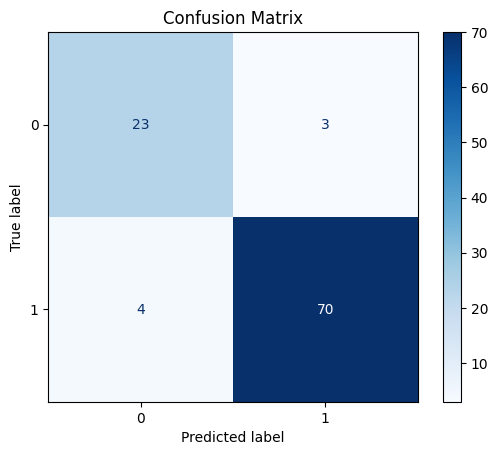

In [1927]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Ploting confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=clf_best.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Actionable Business Insights & Recommendations for Ola

## 1. Customer Segmentation and Personalization

### Insights:
- Analyzing ride frequency, duration, and customer demographics can help identify distinct customer segments.
- Frequent riders may exhibit different behavior compared to occasional users, indicating the need for tailored marketing strategies.

### Recommendations:
- Develop targeted promotions for specific customer segments, such as discounts for frequent riders or incentives for occasional users to encourage more frequent use.
- Implement personalized communication strategies (e.g., push notifications, emails) based on user preferences and behavior.

## 2. Dynamic Pricing Optimization

### Insights:
- Demand patterns vary by time of day, day of the week, and special events, affecting ride availability and pricing.

### Recommendations:
- Utilize real-time data analytics to adjust pricing dynamically based on demand fluctuations, ensuring competitive pricing while maximizing revenue.
- Communicate transparently with customers about pricing changes, especially during peak times, to build trust.

## 3. Fleet Management and Utilization

### Insights:
- Analyzing driver availability, vehicle types, and geographical demand can highlight areas of inefficiency or underutilization.

### Recommendations:
- Optimize fleet deployment by ensuring that vehicles are strategically stationed in high-demand areas, reducing wait times and improving customer satisfaction.
- Consider implementing a rewards program for drivers who maintain high availability during peak hours to incentivize better service.

## 4. Enhancing User Experience

### Insights:
- Customer feedback and ratings can reveal pain points in the user experience, such as app functionality, ride quality, or driver behavior.

### Recommendations:
- Continuously gather and analyze customer feedback to make iterative improvements to the app and service offerings.
- Invest in driver training programs focused on customer service skills to enhance the overall ride experience.

## 5. Expanding Service Offerings

### Insights:
- Identifying underserved markets or customer needs can present opportunities for new services, such as ride-sharing for specific demographics or corporate partnerships.

### Recommendations:
- Explore partnerships with local businesses or events to offer shuttle services, enhancing brand visibility and attracting new users.
- Consider expanding into related services, such as package delivery or logistics, leveraging existing infrastructure.

## 6. Marketing Strategy Optimization

### Insights:
- Understanding the effectiveness of various marketing channels can help allocate resources more efficiently.

### Recommendations:
- Analyze marketing campaign performance metrics to identify high-ROI channels and optimize spending accordingly.
- Use A/B testing for promotional campaigns to determine the most effective messaging and offers.

## 7. Leveraging Technology and Data

### Insights:
- Advanced analytics and machine learning can provide deeper insights into customer behavior and operational efficiency.

### Recommendations:
- Invest in data analytics capabilities to enhance predictive modeling for demand forecasting and route optimization.
- Explore integrating AI-driven chatbots for customer service to handle common inquiries efficiently, improving response times.

## Conclusion
By implementing these insights and recommendations, Ola can enhance its operational efficiency, improve customer satisfaction, and drive revenue growth while maintaining a competitive edge in the ride-hailing market.
